In [498]:
import os
from pathlib import Path

import pytesseract
from pdf2image import convert_from_path
import json
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from huggingface_hub import InferenceClient
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt

load_dotenv()


print("Tesseract version from Python:", pytesseract.get_tesseract_version())

Tesseract version from Python: 5.5.1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [499]:
DATA_DIR = Path("data")
RAW_PDF_DIR = DATA_DIR / "raw_pdfs"
OCR_JSON_DIR = DATA_DIR / "ocr_json"

OCR_JSON_DIR.mkdir(parents=True, exist_ok=True)
print("OCR output folder:", OCR_JSON_DIR)


OCR output folder: data/ocr_json


In [500]:
print("Number of raw PDFs:", len(list(RAW_PDF_DIR.glob("*.pdf"))))
list(RAW_PDF_DIR.glob("*.pdf"))[:5]

Number of raw PDFs: 33


[PosixPath('data/raw_pdfs/2025 Fees _ Charges - BL 2024-201.pdf'),
 PosixPath('data/raw_pdfs/BL 2017-196 A Bylaw to Regulate Signs and Other Advertising Devices.pdf'),
 PosixPath('data/raw_pdfs/BL 2012-79 Property Standards - amended by 2018-82.pdf'),
 PosixPath('data/raw_pdfs/BL 2019-169 A Bylaw to Regulate the Operation of All-terrain Vehicles on Municipal Highways.pdf'),
 PosixPath('data/raw_pdfs/BL 2013-45 A Bylaw to amend BL 2005-206 Dogs running at large.pdf')]

In [501]:
def ocr_pdf_to_json(pdf_path: Path, output_path: Path):
    """
    OCR a scanned PDF into a JSON structure:
    {
      "file_name": "...",
      "pages": [
        {"page_number": 1, "text": "..."},
        {"page_number": 2, "text": "..."},
        ...
      ]
    }
    """
    print(f"Starting OCR for: {pdf_path.name}")
    
    # Convert all pages to images
    pages = convert_from_path(str(pdf_path))
    print(f"Total pages: {len(pages)}")
    
    ocr_pages = []
    
    for i, img in enumerate(pages, start=1):
        print(f"  - OCR on page {i}...")
        text = pytesseract.image_to_string(img, lang="eng")
        ocr_pages.append({
            "page_number": i,
            "text": text
        })
    
    data = {
        "file_name": pdf_path.name,
        "pages": ocr_pages
    }
    
    # Save to JSON
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    
    print(f"OCR complete! Saved to {output_path}")

In [502]:
from pathlib import Path

# Just to be sure these are defined
DATA_DIR = Path("data")
RAW_PDF_DIR = DATA_DIR / "raw_pdfs"
OCR_JSON_DIR = DATA_DIR / "ocr_json"
OCR_JSON_DIR.mkdir(parents=True, exist_ok=True)

for pdf_path in RAW_PDF_DIR.glob("*.pdf"):
    # Create a cleaner JSON file name from the PDF name
    output_name = pdf_path.stem.replace(" ", "_") + ".json"
    output_path = OCR_JSON_DIR / output_name
    
    # Skip if we already have OCR for this file
    if output_path.exists():
        print(f"Skipping (already exists): {output_path.name}")
        continue
    
    print(f"\nProcessing PDF: {pdf_path.name}")
    ocr_pdf_to_json(pdf_path, output_path)


Skipping (already exists): 2025_Fees___Charges_-_BL_2024-201.json
Skipping (already exists): BL_2017-196_A_Bylaw_to_Regulate_Signs_and_Other_Advertising_Devices.json
Skipping (already exists): BL_2012-79_Property_Standards_-_amended_by_2018-82.json
Skipping (already exists): BL_2019-169_A_Bylaw_to_Regulate_the_Operation_of_All-terrain_Vehicles_on_Municipal_Highways.json
Skipping (already exists): BL_2013-45_A_Bylaw_to_amend_BL_2005-206_Dogs_running_at_large.json
Skipping (already exists): BL_2011-59_A_Bylaw_to_Establish_and_Regulate_a_Fire_Department_and_Emergency_Services.json
Skipping (already exists): BL_2011-206_A_Bylaw_to_Prohibit_Debris_on_Private_or_Minicipal_Property.json
Skipping (already exists): BL_2001-129_A_Bylaw_Respecting_Streets_and_Driveway_Controls.json
Skipping (already exists): BL_2005-200_A_Bylaw_Authorize_Permits_for_Overweight_Loads.json
Skipping (already exists): BL_2012-152_A_Bylaw_to_Licence_Regulate_and_Govern_Certain_Businesses_-_Secondhand_Goods.json
Skippi

In [503]:
OCR_JSON_DIR = DATA_DIR / "ocr_json"
CHUNKS_JSON_PATH = DATA_DIR / "bylaw_chunks.json"

print("OCR JSON directory:", OCR_JSON_DIR)
print("Chunks will be saved to:", CHUNKS_JSON_PATH)

OCR JSON directory: data/ocr_json
Chunks will be saved to: data/bylaw_chunks.json


In [504]:
def load_ocr_json_files(ocr_dir: Path):
    docs = []
    for json_path in ocr_dir.glob("*.json"):
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        docs.append(data)
    print(f"Loaded {len(docs)} OCR JSON files.")
    return docs

ocr_docs = load_ocr_json_files(OCR_JSON_DIR)
len(ocr_docs)

Loaded 33 OCR JSON files.


33

In [505]:
def clean_text(text: str) -> str:
    # Replace newlines with spaces
    text = text.replace("\n", " ")
    # Collapse multiple spaces into one
    text = " ".join(text.split())
    return text

In [506]:

def iter_page_chunks_from_document(doc, chunk_size=800, overlap=200):
    """
    doc: dict loaded from one OCR JSON ({file_name, pages: [...]})
    Yields small chunks per page.
    """
    file_name = doc["file_name"]
    bylaw_name = Path(file_name).stem.replace(" ", "_")

    for page in doc["pages"]:
        page_num = page["page_number"]
        page_text = clean_text(page["text"])

        if not page_text:
            continue  # skip empty pages

        text_len = len(page_text)
        if text_len <= chunk_size:
            # Just one chunk for this page
            yield {
                "id": f"{bylaw_name}_p{page_num}_chunk_0",
                "file_name": file_name,
                "bylaw_name": bylaw_name,
                "page_number": page_num,
                "text": page_text,
            }
        else:
            # Split long page into multiple chunks
            start = 0
            chunk_id = 0

            # Safety: make sure chunk_size > overlap so we don't loop forever
            if overlap >= chunk_size:
                raise ValueError("overlap must be smaller than chunk_size")

            while start < text_len:
                end = min(start + chunk_size, text_len)
                chunk_text = page_text[start:end]

                yield {
                    "id": f"{bylaw_name}_p{page_num}_chunk_{chunk_id}",
                    "file_name": file_name,
                    "bylaw_name": bylaw_name,
                    "page_number": page_num,
                    "text": chunk_text,
                }

                chunk_id += 1
                if end == text_len:
                    break  # reached end of page text
                start = end - overlap  # move with overlap and continue


In [507]:
# Build and save chunks from OCR documents
chunks = []
for doc in ocr_docs:
    chunks.extend(iter_page_chunks_from_document(doc, chunk_size=800, overlap=200))

print(f"Generated {len(chunks)} chunks")
CHUNKS_JSON_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(CHUNKS_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(chunks, f, ensure_ascii=False, indent=2)
print(f"Saved chunks to {CHUNKS_JSON_PATH}")


Generated 1534 chunks
Saved chunks to data/bylaw_chunks.json


In [508]:
with open(CHUNKS_JSON_PATH, "r", encoding="utf-8") as f:
    chunks = json.load(f)

print("Number of chunks loaded:", len(chunks))
print("Example keys:", chunks[0].keys())
print("Sample text:", chunks[0]["text"][:200], "...")

Number of chunks loaded: 1534
Example keys: dict_keys(['id', 'file_name', 'bylaw_name', 'page_number', 'text'])
Sample text: THE CORPORATION OF THE CITY OF BELLEVILLE BY-LAW NO. 2007-184 A BY-LAW TO AMEND BY-LAW NUMBER 2005-206, BEING A BY-LAW TO PROVIDE FOR THE LICENSING, REGULATION AND REGISTRATION OF DOGS, WITHIN THE CIT ...


In [509]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

embed_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
print("Loaded embedding model:", EMBEDDING_MODEL_NAME)

Loaded embedding model: sentence-transformers/all-MiniLM-L6-v2


In [510]:
# Extract texts from chunks
texts = [c["text"] for c in chunks]
print("Total texts to embed:", len(texts))

# Create embeddings
embeddings = embed_model.encode(
    texts,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("Embeddings shape before cast:", embeddings.shape, embeddings.dtype)

# FAISS prefers float32
embeddings = embeddings.astype("float32")

# Normalize for cosine similarity
faiss.normalize_L2(embeddings)

print("Embeddings ready. Shape:", embeddings.shape, embeddings.dtype)

Total texts to embed: 1534


Batches: 100%|██████████| 48/48 [00:04<00:00,  9.78it/s]

Embeddings shape before cast: (1534, 384) float32
Embeddings ready. Shape: (1534, 384) float32


In [511]:
VECTOR_DIM = embeddings.shape[1]
index = faiss.IndexFlatIP(VECTOR_DIM)  # IP = inner product
index.add(embeddings)

print("FAISS index size:", index.ntotal)

FAISS index size: 1534


In [512]:
INDEX_PATH = DATA_DIR / "bylaw_faiss.index"
METADATA_PATH = DATA_DIR / "bylaw_metadata.json"

# Save FAISS index
faiss.write_index(index, str(INDEX_PATH))
print("Saved FAISS index to:", INDEX_PATH)

# Build & save metadata (everything except embeddings)
metadata = [
    {
        "id": c["id"],
        "file_name": c["file_name"],
        "bylaw_name": c.get("bylaw_name"),
        "page_number": c.get("page_number"),
        "text": c["text"],
    }
    for c in chunks
]

with open(METADATA_PATH, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Saved metadata to:", METADATA_PATH)

Saved FAISS index to: data/bylaw_faiss.index
Saved metadata to: data/bylaw_metadata.json


In [513]:
index = faiss.read_index(str(INDEX_PATH))

with open(METADATA_PATH, "r", encoding="utf-8") as f:
    metadata = json.load(f)

In [514]:
def shorten_bylaw_name(name):
    # Replace underscores with spaces
    name = name.replace("_", " ")

    if len(name) > 30:
        name = name[:15] + "..."
    
    return name.strip()

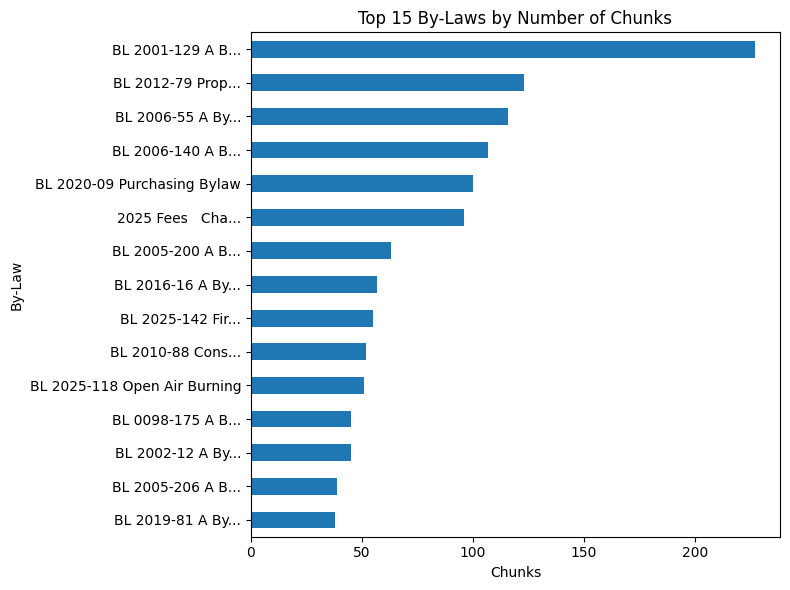

In [515]:
df = pd.DataFrame(metadata)  # metadata from bylaw_metadata.json

TOP_N = 15
df["short_name"] = df["bylaw_name"].apply(shorten_bylaw_name)

top_counts = df["short_name"].value_counts().head(TOP_N).sort_values(ascending=True)

# top_counts = bylaw_counts.tail(TOP_N)

plt.figure(figsize=(8, 6))
top_counts.plot(kind="barh")
plt.title(f"Top {TOP_N} By-Laws by Number of Chunks")
plt.xlabel("Chunks")
plt.ylabel("By-Law")
plt.tight_layout()
plt.show()

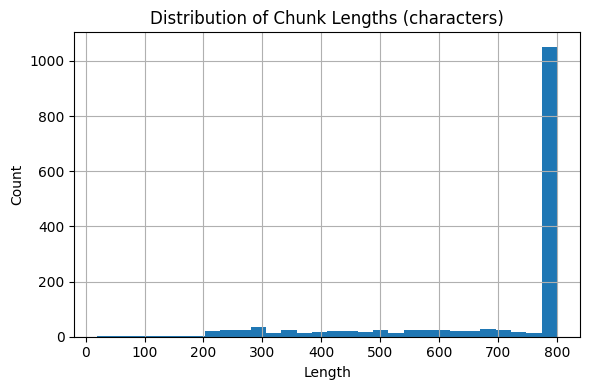

count    1534.000000
mean      698.448501
std       178.320280
min        20.000000
25%       651.000000
50%       800.000000
75%       800.000000
max       800.000000
Name: text_len, dtype: float64

In [516]:
df["text_len"] = df["text"].str.len()

plt.figure(figsize=(6,4))
df["text_len"].hist(bins=30)
plt.title("Distribution of Chunk Lengths (characters)")
plt.xlabel("Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df["text_len"].describe()

In [517]:
def retrieve_top_k(query: str, k: int = 5):
    # 1. Embed the query
    q_emb = embed_model.encode([query], convert_to_numpy=True).astype("float32")
    faiss.normalize_L2(q_emb)

    # 2. Search FAISS index
    D, I = index.search(q_emb, k)
    
    # 3. Collect results
    results = []
    for score, idx in zip(D[0], I[0]):
        if idx == -1:
            continue
        chunk_info = metadata[idx]
        results.append({
            "score": float(score),
            "id": chunk_info["id"],
            "file_name": chunk_info["file_name"],
            "bylaw_name": chunk_info.get("bylaw_name"),
            "page_number": chunk_info.get("page_number"),
            "text": chunk_info["text"],
        })
    return results

In [518]:
query = "What fees and charges does the city collect?"
results = retrieve_top_k(query, k=3)

print("Query:", query)
for i, r in enumerate(results, start=1):
    print(f"\nResult {i}:")
    print("Score:", round(r["score"], 3))
    print("File:", r["file_name"])
    print("Bylaw:", r["bylaw_name"])
    print("Page:", r["page_number"])
    print("Text sample:", r["text"][:300], "...")

Query: What fees and charges does the city collect?

Result 1:
Score: 0.61
File: 2025 Fees _ Charges - BL 2024-201.pdf
Bylaw: 2025_Fees___Charges_-_BL_2024-201
Page: 10
Text sample: Change of Ownership — (Property Taxes $25 $30 Change of Occupancy/New Account — Water Bill} New Account $50 $50 Transfer to Taxes — per transaction $20 $20 Payment Transfer (wrong account number) $30 $30 Refund/Overpayment recovery (Tax Bill, Water $30 $35 Bill) Title Search — Property in second yea ...

Result 2:
Score: 0.564
File: BL 2012-79 Property Standards - amended by 2018-82.pdf
Bylaw: BL_2012-79_Property_Standards_-_amended_by_2018-82
Page: 34
Text sample: n convicted. If the owner fails to do the remedial or maintenance work necessary to meet the requirements of this Bylaw or an order issued pursuant to this Bylaw the Municipality may do the required remedial or maintenance work at the owner's expense and the Municipality may recover the costs of doi ...

Result 3:
Score: 0.554
File: BL 2016-16 A 

In [519]:
HF_TOKEN = os.getenv("HUGGINGFACE_API_TOKEN")
print("HF token found?", HF_TOKEN is not None)

HF token found? True


In [520]:
HF_LLM_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"
# HF_LLM_MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
# HF_LLM_MODEL_NAME = "mistralai/Mistral-7B-v0.1"
# HF_LLM_MODEL_NAME = "openai/gpt-oss-120b"
# HF_LLM_MODEL_NAME = "meta-llama/Meta-Llama-3-8B"

client = InferenceClient(
    model=HF_LLM_MODEL_NAME,
    token=HF_TOKEN,
    provider="auto"
)


In [521]:
def build_context_from_results(results):
    """
    results: list of dicts from retrieve_top_k
    Returns: a single string with sources separated by --- markers.
    """
    parts = []
    for r in results:
        header = f"[{r.get('bylaw_name')} | page {r.get('page_number')} | {r.get('file_name')}]"
        parts.append(header + "\n" + r["text"])
    return "\n\n---\n\n".join(parts)

In [522]:
import ollama

OLLAMA_MODEL_NAME = "llama3" 

In [523]:
def call_llm_with_context(question: str, context: str, max_new_tokens: int = 300) -> str:
    system_prompt = (
        "You are an assistant that answers questions about City of Belleville by-laws.\n"
        "Use ONLY the information in the provided CONTEXT.\n"
        "If the answer is not clearly in the context, say you are not sure and suggest "
        "contacting the City of Belleville for confirmation.\n\n"
        "Format your answer as:\n"
        "- First, a short 1–2 sentence summary in plain language.\n"
        "- Then, a bullet list focusing ONLY on fees or dollar amounts relevant to the question.\n"
        "- Each bullet must be of the form: '<item or waste type>: $<amount> (short description if needed)'.\n"
        "- Do NOT include operational rules (like number of lifts, tag requirements, schedule rules) in the bullet list;\n"
        "  those can be mentioned in the summary if important.\n"
        "- Do NOT leave any bullet unfinished. Do NOT end the answer with a hanging '-' or incomplete sentence.\n"
        "Do NOT invent information that is not supported by the context.\n"
        "Do NOT ask or answer extra questions. Just answer the user's question.\n"  
    )

    user_message = (
        f"Here is the context from Belleville by-laws:\n\n"
        f"{context}\n\n"
        f"Based ONLY on the context above, answer this question clearly and concisely:\n"
        f"{question}"
    )

    # response = client.chat_completion(
    #     model=HF_LLM_MODEL_NAME,
    #     messages=[
    #         {"role": "system", "content": system_prompt},
    #         {"role": "user", "content": user_message},
    #     ],
    #     max_tokens=max_new_tokens,
    #     temperature=0.2,
    # )

    # for meta/llama
    # prompt = (
    #         f"System: {system_prompt}\n\n"
    #         f"{user_message}\n\n"
    #         "Answer:"
    #     )

    # resp = client.text_generation(
    #     model=HF_LLM_MODEL_NAME,
    #     prompt=prompt,
    #     max_new_tokens=max_new_tokens,
    #     temperature=0.2,
    # )
    # return resp.strip()

    # for local ollama
    response = ollama.chat(
        model = "llama3",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message},
        ],
        options={
            "num_predict": max_new_tokens,
            "temperature": 0.2,
        }
    )

    # msg = response.choices[0].message
    content = response["message"]["content"]
    # content = msg["content"] if isinstance(msg, dict) else msg.content
    return content.strip()

In [524]:
def answer_question_with_rag(question: str, k: int = 5):
    q_lower = question.lower().strip()

    # 1. Handle greetings / capability questions explicitly
    greeting_phrases = [
        "hello", "hi", "hey",
        "what can you do", "who are you",
        "help", "how can you help me",
    ]

    if any(p in q_lower for p in greeting_phrases):
        intro_answer = (
            "Hi! I’m the Belleville By-Law Assistant.\n\n"
            "- I can help you understand City of Belleville by-laws in plain language.\n"
            "- You can ask about things like parking rules, noise restrictions, property standards,\n"
            "  fees and charges, animals/pets, streets and driveways, and other municipal rules.\n"
            "- I’ll look up the relevant by-law sections and summarize them for you, and I’ll tell you\n"
            "  which by-law and page the information comes from.\n\n"
            "Try asking something like:\n"
            "- \"Can I park on the street overnight in Belleville?\"\n"
            "- \"What are the fees for a change of ownership?\"\n"
            "- \"Are there any noise restrictions at night?\""
        )
        return {
            "answer": intro_answer,
            "sources": [],
        }

    # 2. Normal RAG flow: retrieve top-k relevant chunks
    results = retrieve_top_k(question, k=k)
    if not results:
        return {
            "answer": (
                "I couldn’t find any relevant sections in the by-laws for that question. "
                "Try asking specifically about parking, noise, fees, property standards, "
                "streets/driveways, or other Belleville by-laws."
            ),
            "sources": [],
        }

    # Check top similarity score to see if this question is relevant at all
    top_score = results[0]["score"]
    if top_score < 0.35:  # you can tune this threshold
        return {
            "answer": (
                "I checked the by-laws I have, but nothing seems clearly related to that question.\n\n"
                "I’m best at answering questions specifically about City of Belleville by-laws — "
                "for example parking rules, noise by-laws, fees and charges, or property-related rules."
            ),
            "sources": [],
        }

    # 3. Build context string from the retrieved chunks
    context = build_context_from_results(results)
    
    # 4. Get LLM answer (summary + bullet list)
    main_answer = call_llm_with_context(question, context)
    
    # 5. Build structured source info from results
    sources = [
        {
            "file_name": r["file_name"],
            "bylaw_name": r["bylaw_name"],
            "page_number": r["page_number"],
            "score": r["score"],
        }
        for r in results
    ]

    # 6. Build final source line
    seen = set()
    source_bits = []
    for s in sources:
        key = (s["bylaw_name"], s["page_number"])
        if key in seen:
            continue
        seen.add(key)
        if s["bylaw_name"] is not None and s["page_number"] is not None:
            source_bits.append(f"{s['bylaw_name']} (page {s['page_number']})")

    if source_bits:
        source_line = "_Source by-laws: " + ", ".join(source_bits) + "._"
        full_answer = main_answer + "\n\n" + source_line
    else:
        full_answer = main_answer

    return {
        "answer": full_answer,
        "sources": sources,
    }

In [525]:
examples = [
    "What fees and charges does the city collect?",
    "What are the waste collection fees?",
    "Can you tell me about fees for automatic alarms?",
]

rows = []
for q in examples:
    results = retrieve_top_k(q, k=1)
    for r in results:
        rows.append({
            "question": q,
            "bylaw_name": r["bylaw_name"],
            "page": r["page_number"],
            "score": r["score"],
        })

pd.DataFrame(rows)

,question,bylaw_name,page,score
0,What fees and charges does the city collect?,2025_Fees___Charges_-_BL_2024-201,10,0.610128
1,What are the waste collection fees?,BL_0098-175_A_Bylaw_for_Establishing_Waste_Col...,14,0.605341
2,Can you tell me about fees for automatic alarms?,BL_2010-40_A_Bylaw_to_Impose_Fees_for_Automati...,2,0.546588


In [526]:
def rag_chat(message, history):
    result = answer_question_with_rag(message, k=5)
    answer = result["answer"]

    # Build a simple sources text block
    if result["sources"]:
        src_lines = ["\n\n**Sources:**"]
        for s in result["sources"]:
            src_lines.append(
                f"- `{s['bylaw_name']}` (page {s['page_number']}, score={s['score']:.3f})"
            )
        answer = answer + "\n" + "\n".join(src_lines)

    return answer

In [527]:
import gradio as gr

demo = gr.ChatInterface(
    fn=rag_chat,
    title="⚖️ Belleville By-Law Assistant",
    description=(
        "Ask questions about City of Belleville by-laws (parking, noise, waste, fees, "
        "property standards, streets/driveways, etc.).\n\n"
        "I will search the by-laws and summarize the relevant sections for you."
    ),
    examples=[
        "Can I park on the street overnight in Belleville?",
        "What are the waste collection fees?",
        "What fees and charges does the city collect?",
        "Are there any noise restrictions at night?",
    ],
)

demo.launch()

/Users/soul./Desktop/Rahul/Natural Language Processing/Belleville By-Law Bot/.venv/lib/python3.12/site-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.
